In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import itertools
from tqdm import tqdm_notebook

# Functions and Filters

In [2]:
def conc(t, n):
    tmp = t
    for _ in range(n-1):
        t = np.concatenate((t,tmp))
    return t
#################################################################
def make_noise(sig, snr):
    #function to make noise signal based on given SNR
    k = 10**(-snr/20) #signal noise ratio
    variance = k*np.var(sig)
    noise = np.random.normal(0, scale=variance  ,size=len(sig)) #(mean, variance, length)
    return noise, variance
##################################################################
def gaussian_kernel(u1, u2, h):
    #Gaussian kernel for 2 signals
    k = np.exp(-(np.sum((np.array(u1)-np.array(u2))**2, axis=0))*h)
    return k
###################################################################    
def LMS_test(signal, noisy, w):
    #function to test the LMS filter 
    test_error=[]
    filtered_signal=[]
    filter_size=len(w)
    for i in range(len(signal)-filter_size):
        f = np.dot(w, noisy[i:i+filter_size])
        filtered_signal.append(f)
        e = signal[i+filter_size]-f
        test_error.append(e**2)
    general_error = np.mean(test_error)
    return filtered_signal, general_error
####################################################################
def LMS_train(desire, inp, t_signal, t_noisy, filter_size, lr, epochs=1):
    #function to train the LMS filter
    w = np.zeros(filter_size)
    error = []
    for _ in range(epochs):
        for i in range (len(desire)-filter_size):
            e = desire[i+filter_size] - np.dot(w, inp[i:i+filter_size])
            w = w + lr*e*inp[i:i+filter_size]

        #test the filter every 50 iterations
            if i%50 == 0:
                filtered_signal, test_error = LMS_test(t_signal, t_noisy,w)
                error.append(test_error)
    return w, error, filtered_signal
####################################################################
def KLMS_train(desire, inp,test_data, test_noisy, filter_size, lr, kernel, h, epochs=1):
    #train function of kernel LMS
    desire = conc(desire, epochs)
    inp = conc(inp, epochs)
    delay = filter_size
    N_tr = len(desire)-delay
    e = np.zeros(len(desire))
    error = []
    a = []
    f = []
    e[0]= desire[delay]
    u = np.zeros((delay, N_tr))
    for j in range(N_tr):
        u[:,j]=inp[j:j+delay]
    a.append(lr*e[0])
    for i in range(N_tr-1):
        k = gaussian_kernel( u[:,i+1:i+2], u[:,:i+1], h)
        ff = np.dot(a[-len(k):], k)
        f.append(ff)
        e[i+1]= desire[i+delay]-ff
        a.append(lr*e[i+1])
        #test #######
        if i%50 == 0: 
            #print(np.int(i/len(desire)*100), "%")
            klms_filtered, error_klms = KLMS_test(test_data, test_noisy, desire,filter_size, a, h)
            error.append(np.mean(np.asarray(error_klms)**2))
#     print("train done")
    return a, error
#######################################################################
def KLMS_test(test_signal,test_noisy, train_signal,filter_size, a, h):
    #test funtion for kernel LMS
    delay = filter_size
    error = []
    N_tr = len(train_signal)-delay
    N_te = len(test_signal)-delay
    output = np.zeros(len(test_signal))
    d = np.zeros((delay, N_tr))
    x = np.zeros((delay, N_te))
    for j in range(N_tr):
        d[:,j]=train_signal[j:j+delay]
    for j in range(N_te):
        x[:,j]=test_noisy[j:j+delay]
    output[:delay] = test_signal[:delay]
    for i in range(N_te):
        j = i+delay
        k = gaussian_kernel(x[:, i:i+1], d[:,:len(a)], h)
#         print(np.asarray(a).shape)
#         print(k.shape)
        output[j] = np.dot(np.asarray(a), k)
#         print(output[i])
        error.append((test_signal[j] - output[j])**2)
    #print("test  done")
    return output, error

def load_data(non_linear = False):
    #loading data - extra non-linearity can be added by setting non_linear = True
    mat_test = "C:/Users/nikolatesla/Desktop/Apative FIlter/Test.mat"
    mat_train = "C:/Users/nikolatesla/Desktop/Apative FIlter/Training.mat"
    snr = 1
    xt= loadmat(mat_test)["x_test"].reshape((10000))
    x = loadmat(mat_train)["x_training"].reshape((500))
    noise, noise_variance = make_noise(xt, snr)
    y = x + noise[:len(x)]
    yt = xt + noise
    if non_linear:
        x = x**3 - np.sin(x)
        y = y**3 - np.sin(y)
        xt = xt**3 - np.sin(xt)
        yt = yt**3 - np.sin(yt)
    return x, y, xt, yt

## Loading data 

In [3]:
train, train_noisy, test, test_noisy = load_data(non_linear=True)

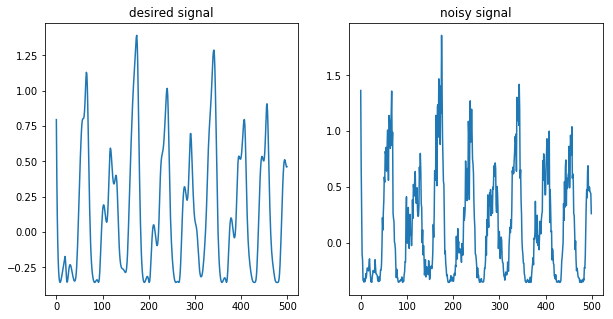

In [51]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.plot(train)
plt.title("desired signal")
fig.add_subplot(1,2,2)
plt.plot(train_noisy)
plt.title("noisy signal")
plt.savefig("signals.pdf")

## Hyperparameter Estimation

estimated h:  1.6560274770024002
estimated lr limit: 0.1167
alphas:  [1.8232e+01 1.7261e+00 6.0270e-01 3.0360e-01 1.8230e-01 1.1400e-02
 3.7000e-03 1.8000e-03]
learning rates:  [0.001, 0.008, 0.04, 0.1]
filter sizes:  [5, 10, 20, 50]


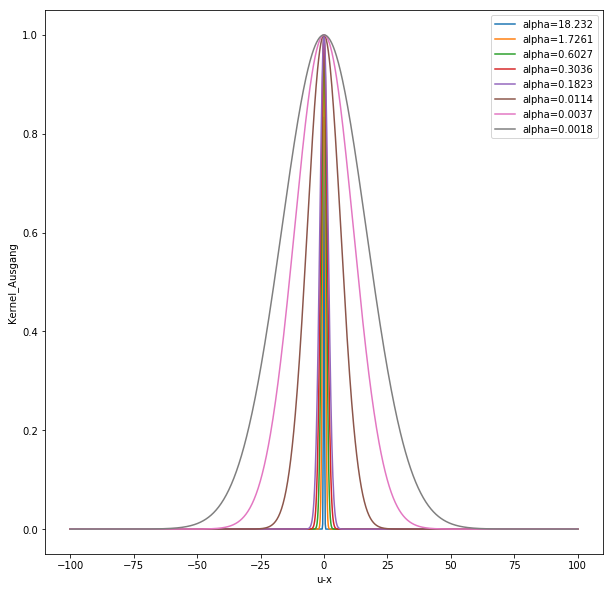

In [129]:
#pramater estimation

#alpha: kernel parameter
signal = train
iqr = np.subtract(*np.percentile(signal, [75, 25]))
h = 1.06* np.minimum(np.std(signal), iqr/1.34)* len(signal)**(1/5)
print("estimated h: ",h)
hh = np.concatenate((np.linspace(h/10, h, 4, endpoint=False), np.linspace(h, 10*h, 4)))

alphas = np.around((0.5 * 1/hh**2), decimals=4)

#learning rate
import scipy.signal
filter_size = 10
n = len(signal)-filter_size
u = np.zeros((filter_size, n))
for j in range(n):
        u[:,j]=signal[j:j+filter_size]

R = np.corrcoef(u)
lr_value = np.around(1/np.max(np.linalg.eigvals(R)), decimals=4)
print("estimated lr limit:", lr_value)
lr_kernel = [0.001, 0.008, 0.04, 0.1]

#filter size
filter_size_kernel = [5,10,20,50]
print("alphas: ", alphas)
print("learning rates: ", lr_kernel)
print("filter sizes: ", filter_size_kernel)
plt.figure(figsize=(10,10))
xx = np.linspace(-100, 100, 1000)
for a in iter(alphas):
    y = np.exp((-(xx)**2)*a)
    plt.plot(xx, y, label="alpha="+np.str(a))
plt.legend()
plt.xlabel("u-x")
plt.ylabel("Kernel_Ausgang")
plt.savefig("distributions.pdf")

## Training LMS filter with different parameter

In [82]:
#LMS 
lr_lms = lr_kernel
filter_size = filter_size_kernel
epochs = 1
result_lms = pd.DataFrame(columns=["lr", "size", "error", "w", "name"])
n_cases = len(lr_lms)*len(filter_size)
with tqdm_notebook(total=n_cases) as pbar:
    for lr, size in itertools.product(lr_lms, filter_size):
        w, e, filtered_signal= LMS_train(train, train_noisy, test[:1000], test_noisy[:1000], size, lr , epochs=epochs)
        name = "  f_size="+np.str(size) + " lr="+np.str(lr)
        result_lms = result_lms.append(pd.DataFrame([[lr, size, e, w, name]], columns=["lr", "size", "error", "w", "name"]), 
                                     ignore_index=True)
        pbar.update(1)

## Cross_Validation LMS

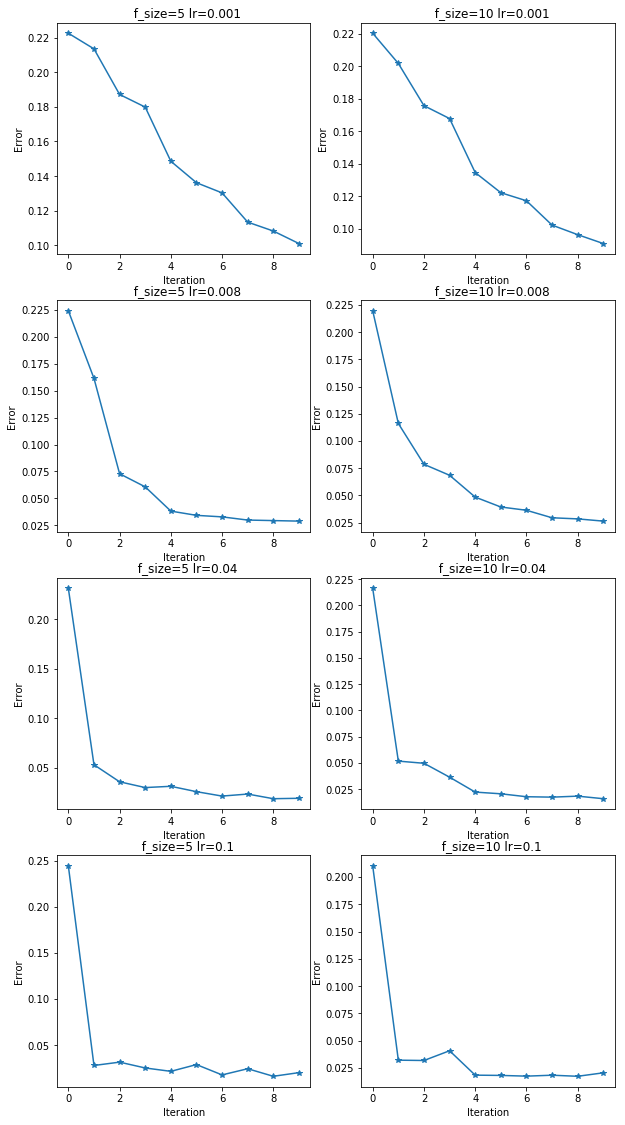

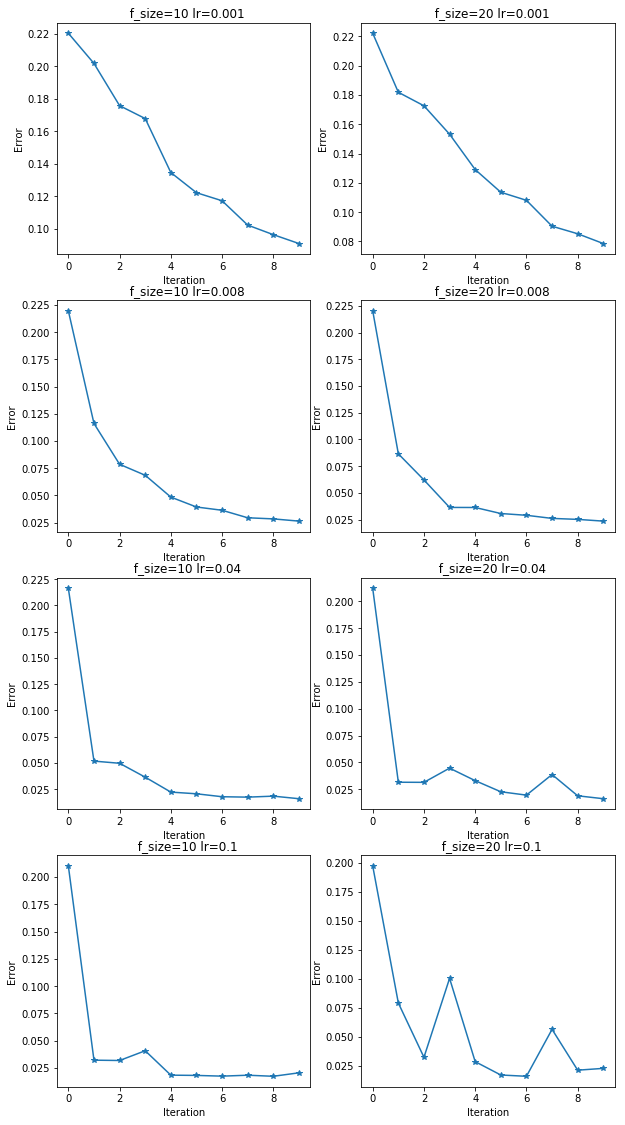

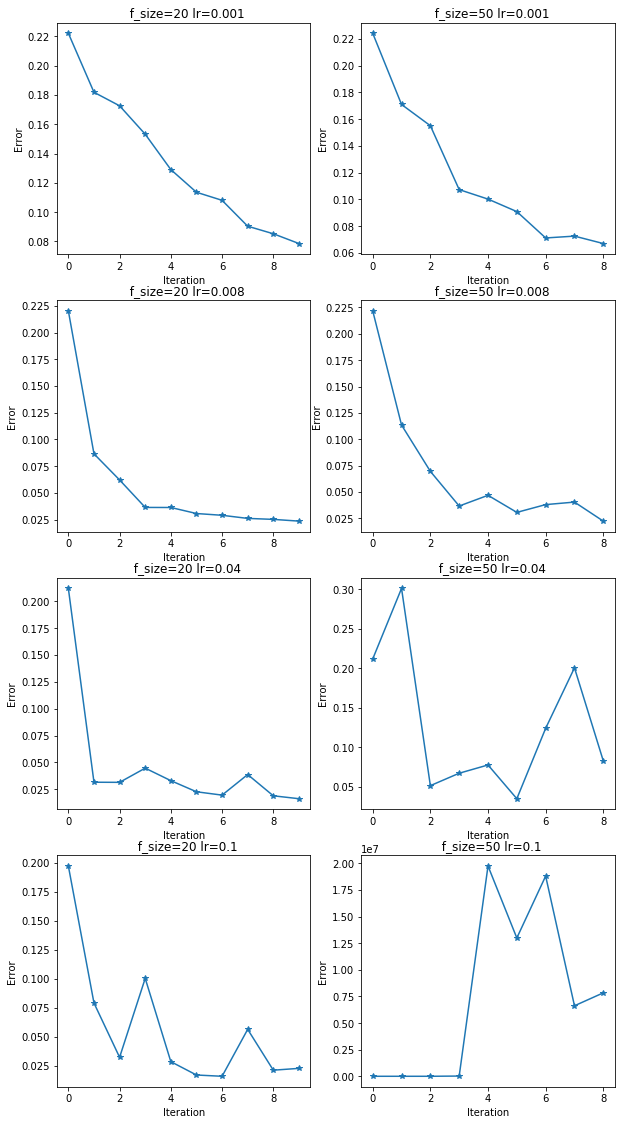

In [93]:
for i in range(len(filter_size)-1):
    fig = plt.figure(figsize=(10,40))
    n=0
    for j in range(n_cases):
        if result_lms["size"][j] == filter_size[i] or result_lms["size"][j] == filter_size[i+1]:
            fig.add_subplot(8,2,n+1)
            plt.plot(result_lms["error"][j], "*-")
            plt.title(result_lms["name"][j])
            plt.xlabel("Iteration")
            plt.ylabel("Error")
            n += 1
    address = "size_lms="+np.str(filter_size[i])+"_"+np.str(filter_size[i+1])+".png"
    plt.savefig(address)
    

## Training KLMS

In [101]:
result_klms = pd.DataFrame(columns=["lr", "alpha", "size", "error", "name"])
error = []
n_cases = len(filter_size_kernel)*len(alphas)*len(lr_kernel)
epochs = 1
with tqdm_notebook(total = n_cases) as pbar:
    for lr, size, alpha in itertools.product(lr_kernel, filter_size_kernel, alphas):
        name = "alpha="+np.str(alpha)+"  f_size="+np.str(size) + " lr="+np.str(lr)
        _, e = KLMS_train(train, train_noisy ,test[:1000], test_noisy[:1000], size , lr, "gaussian", alpha, epochs=epochs)
        result_klms = result_klms.append(pd.DataFrame([[lr,alpha, size, e, name]], columns=["lr", "alpha", "size", "error", "name"]), 
                                     ignore_index=True)
        pbar.update(1)
        
import winsound
duration = 3000  # milliseconds
freq = 880  # Hz
winsound.Beep(freq, duration)


## Cross_Validation KLMS

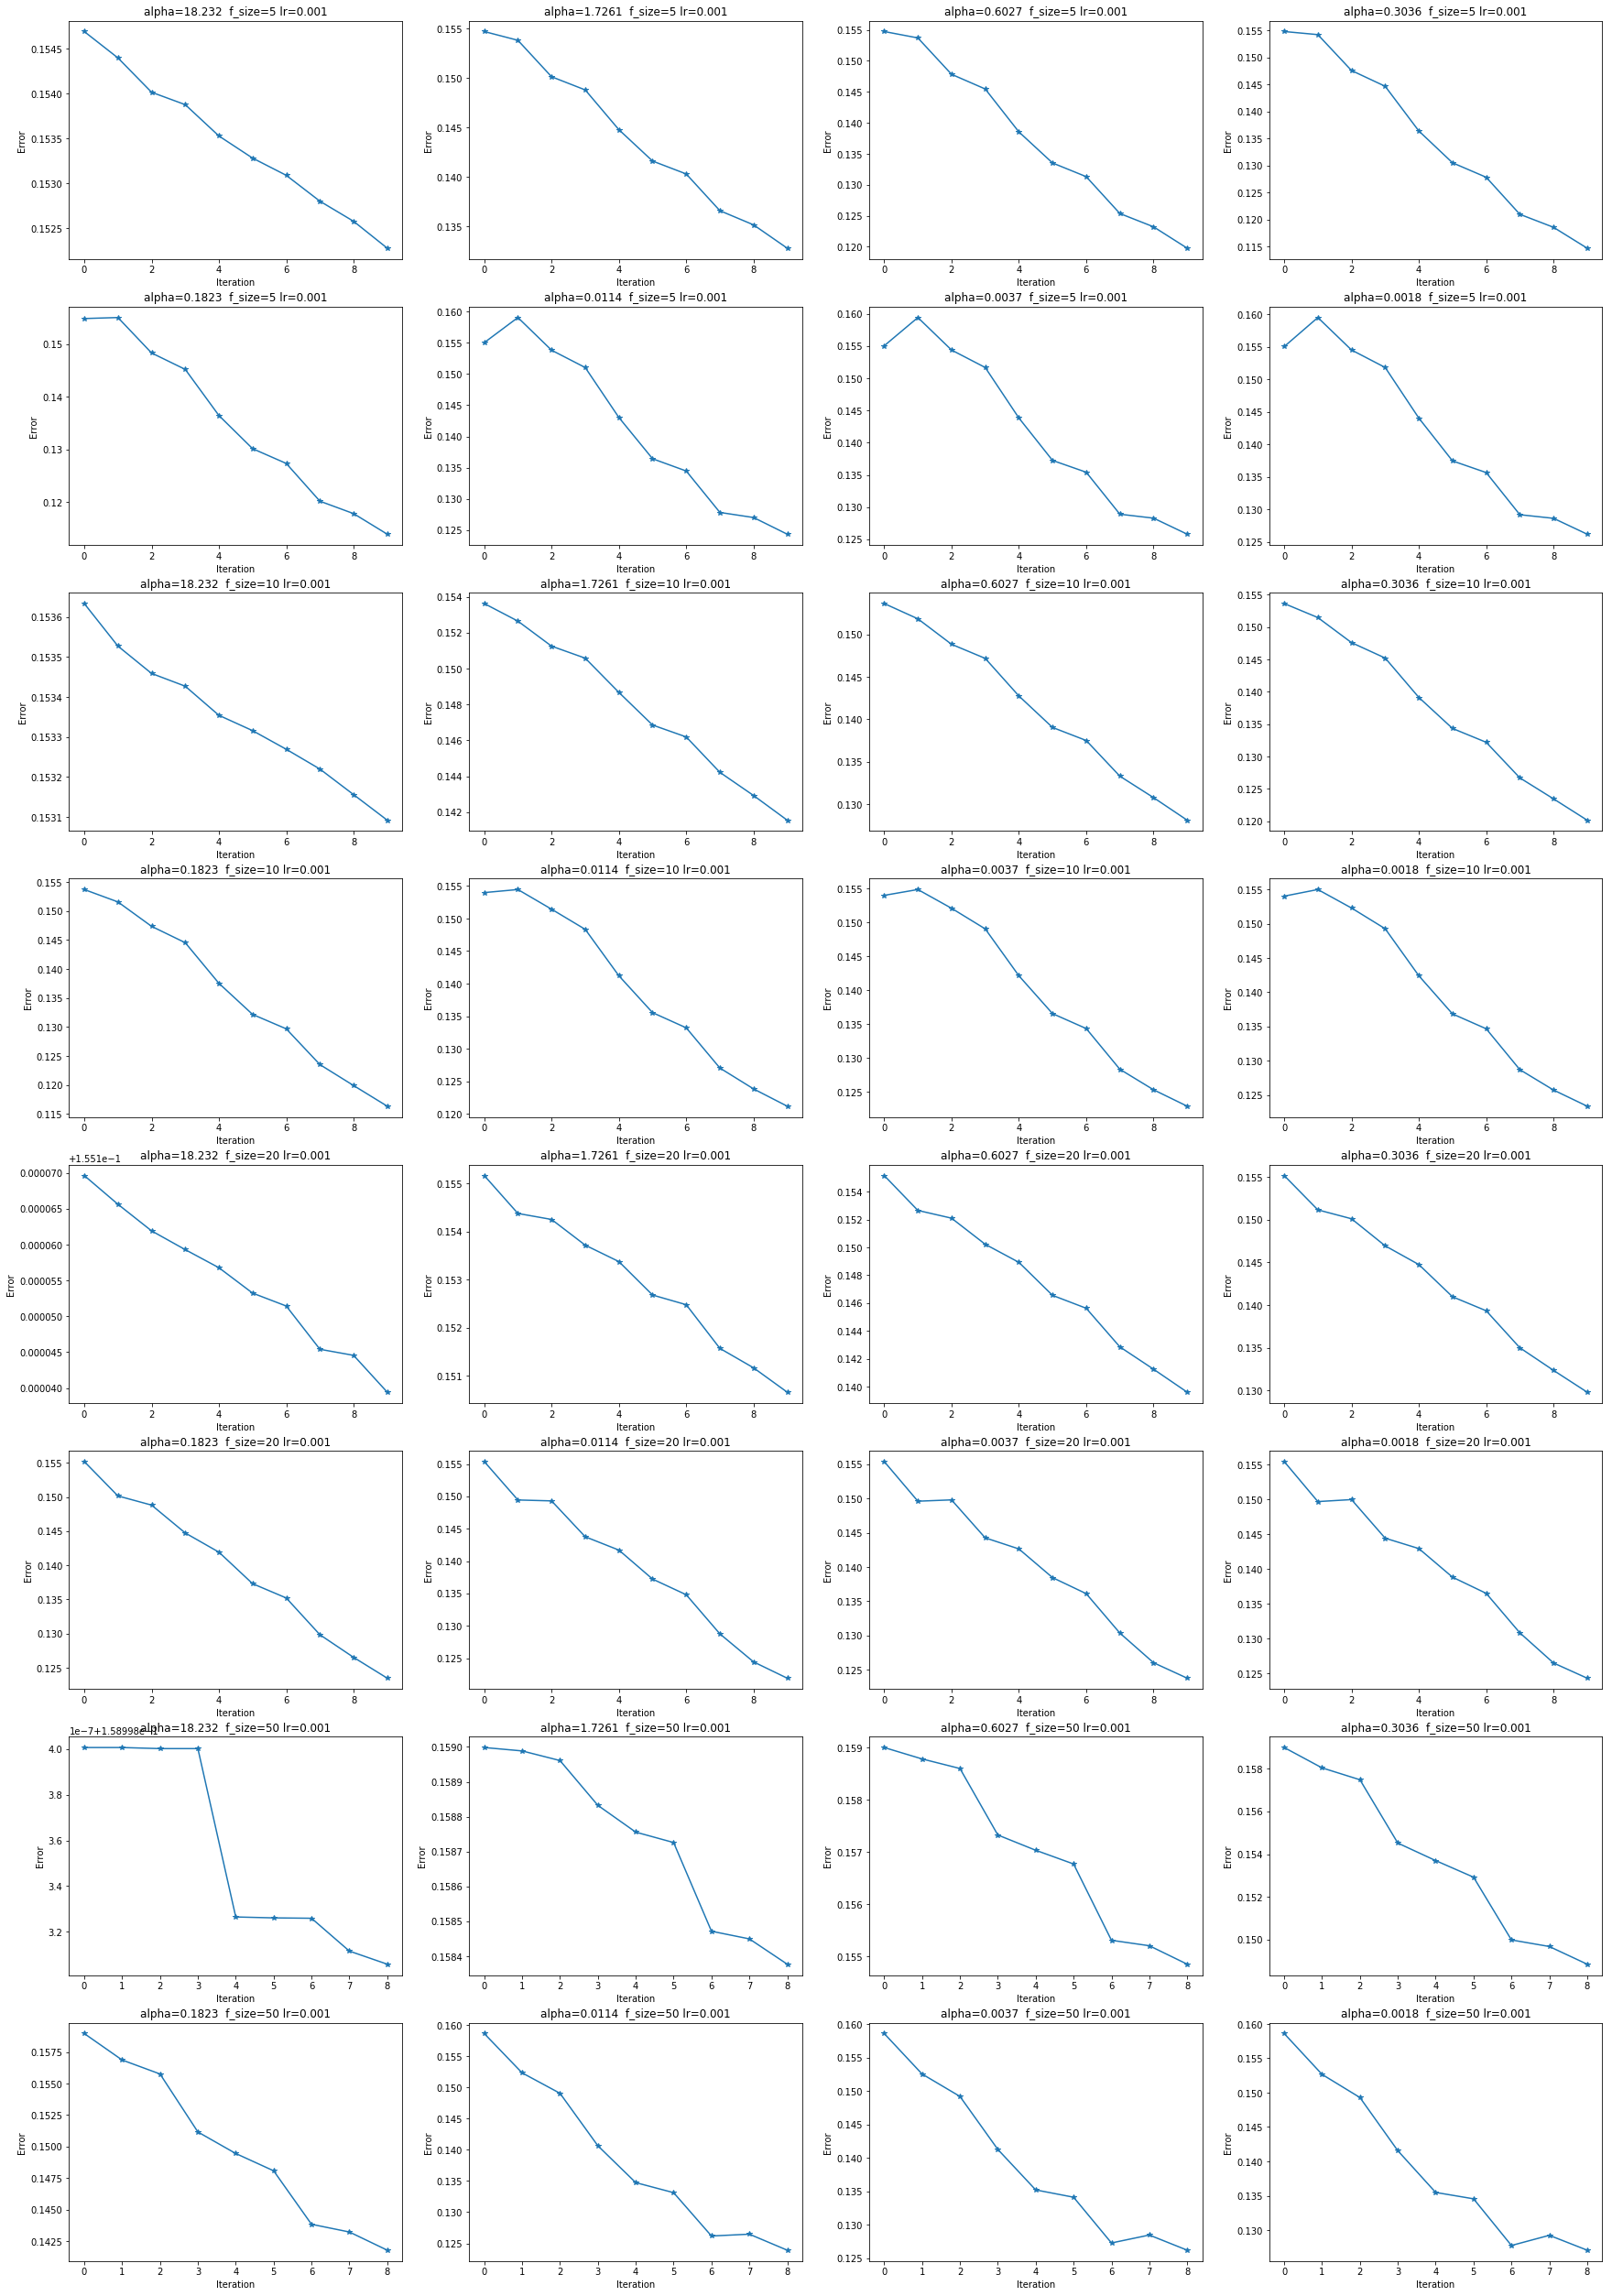

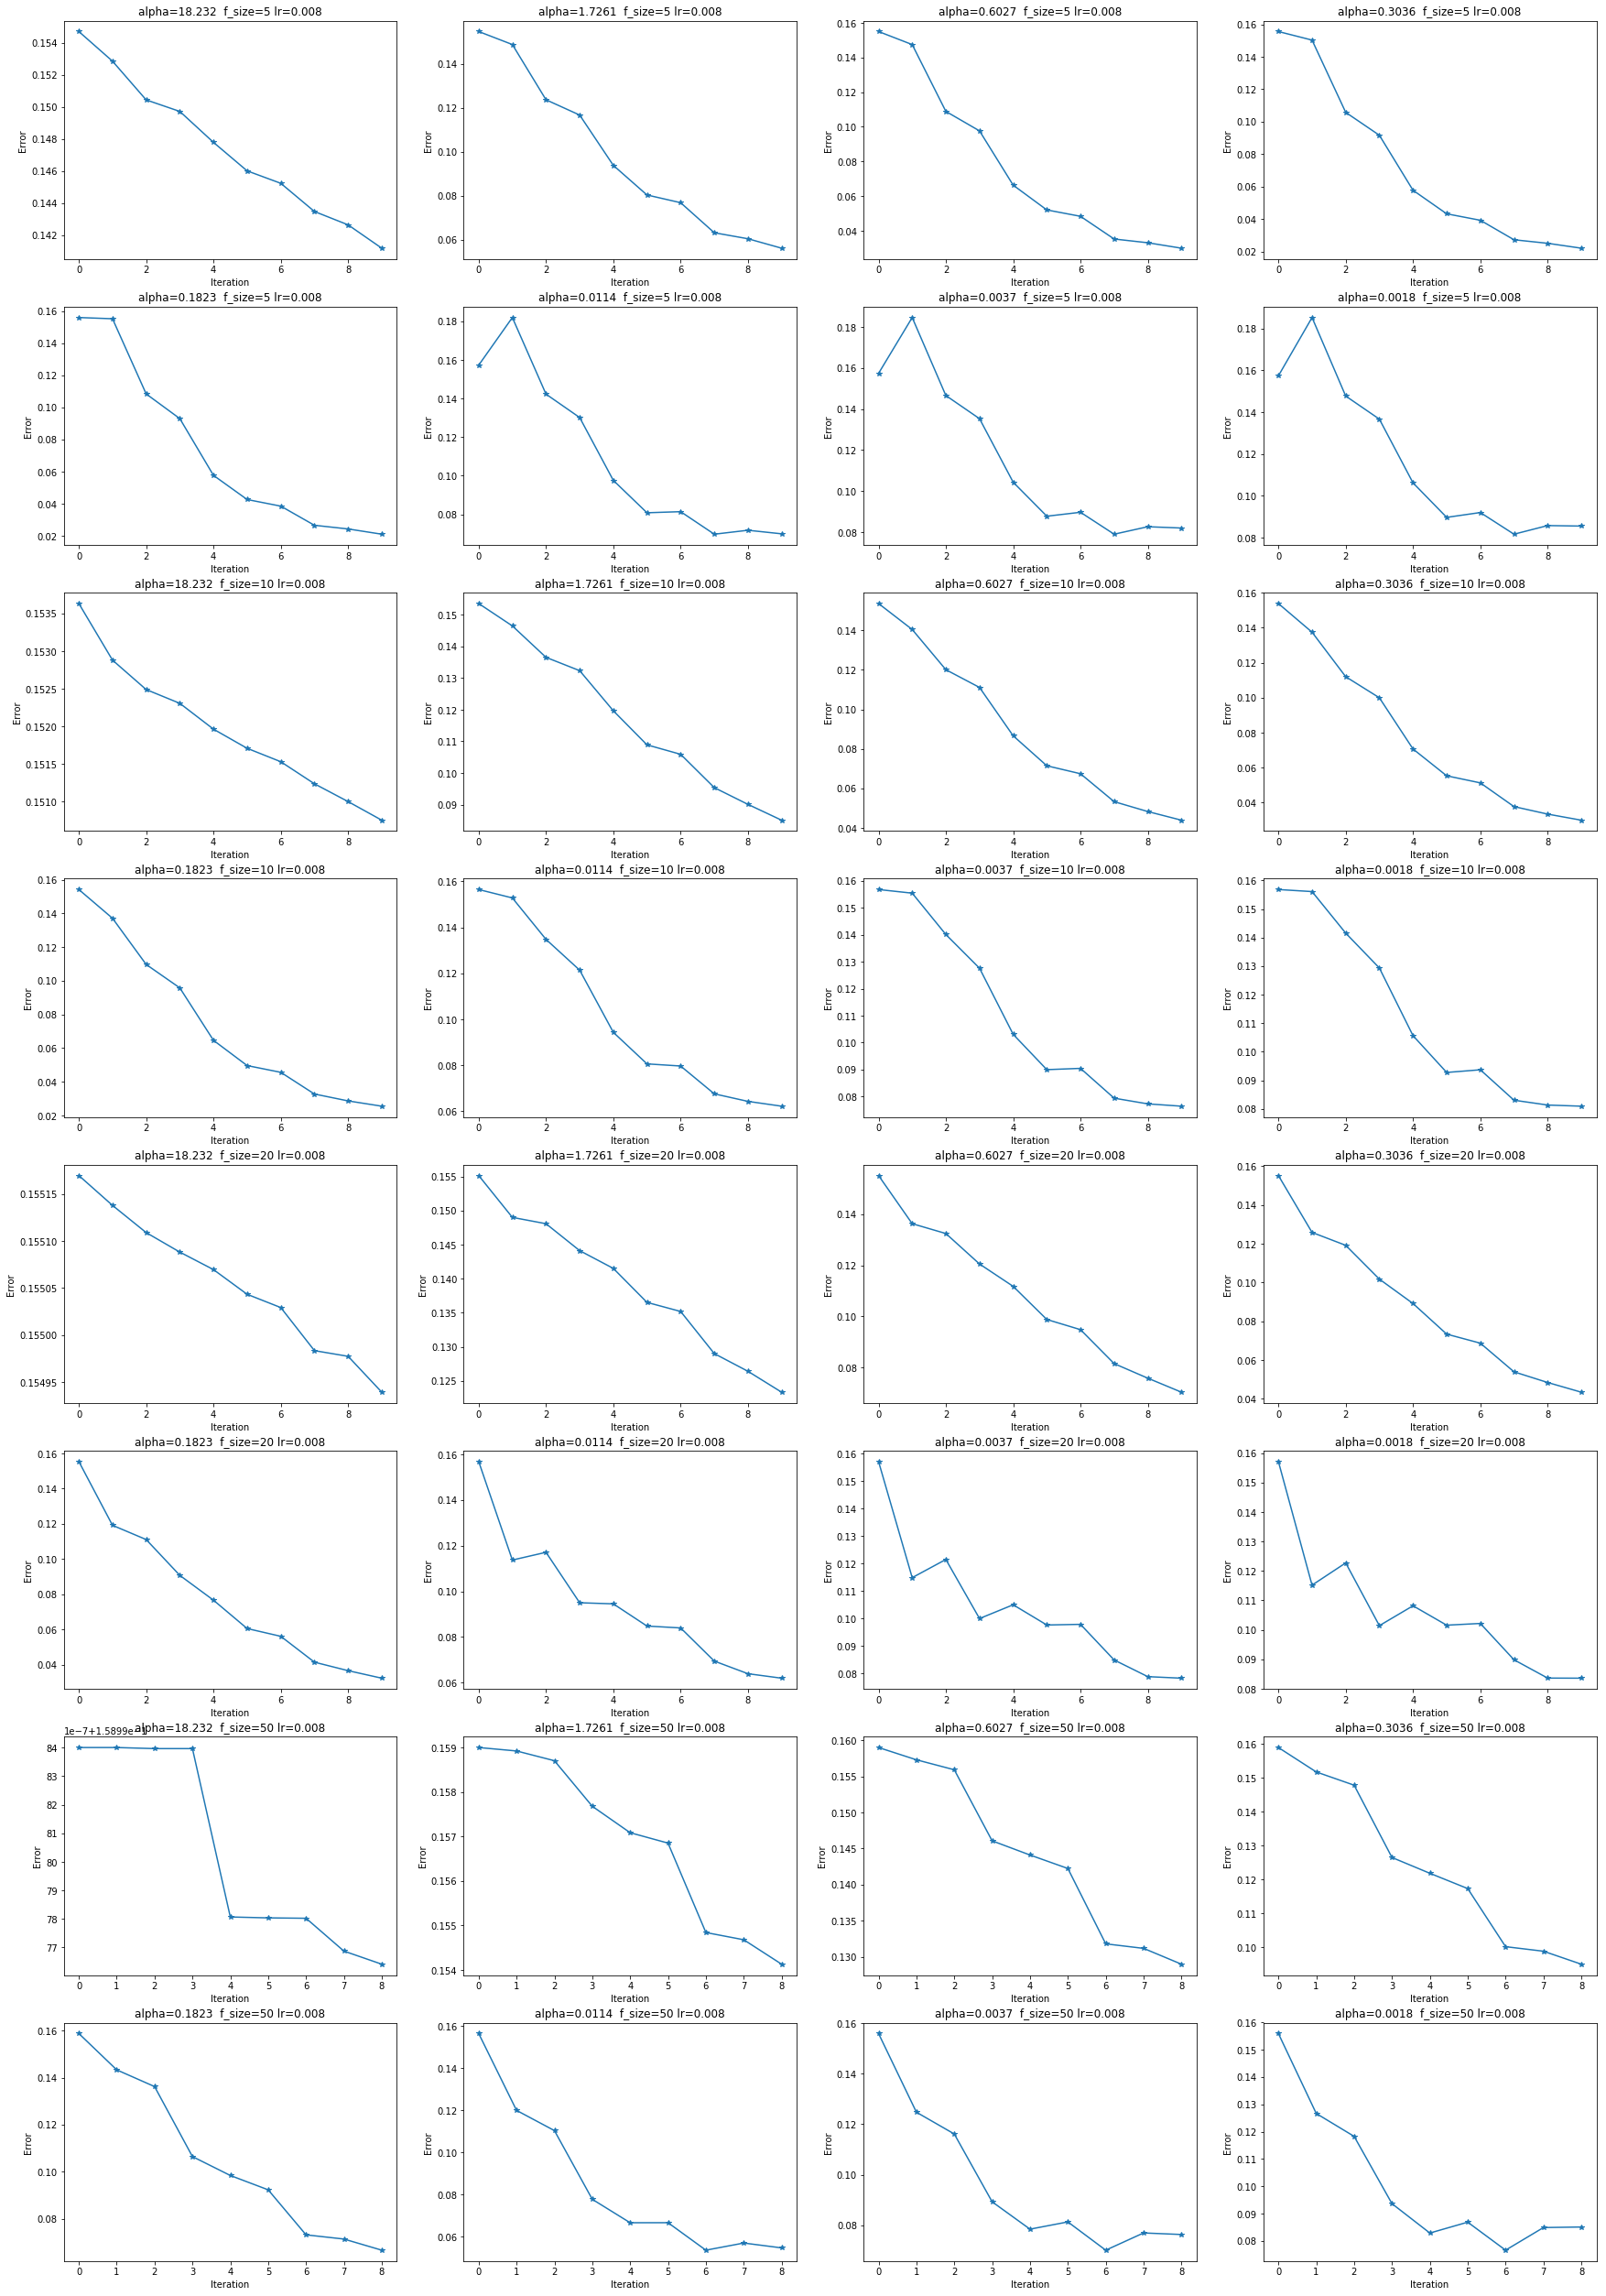

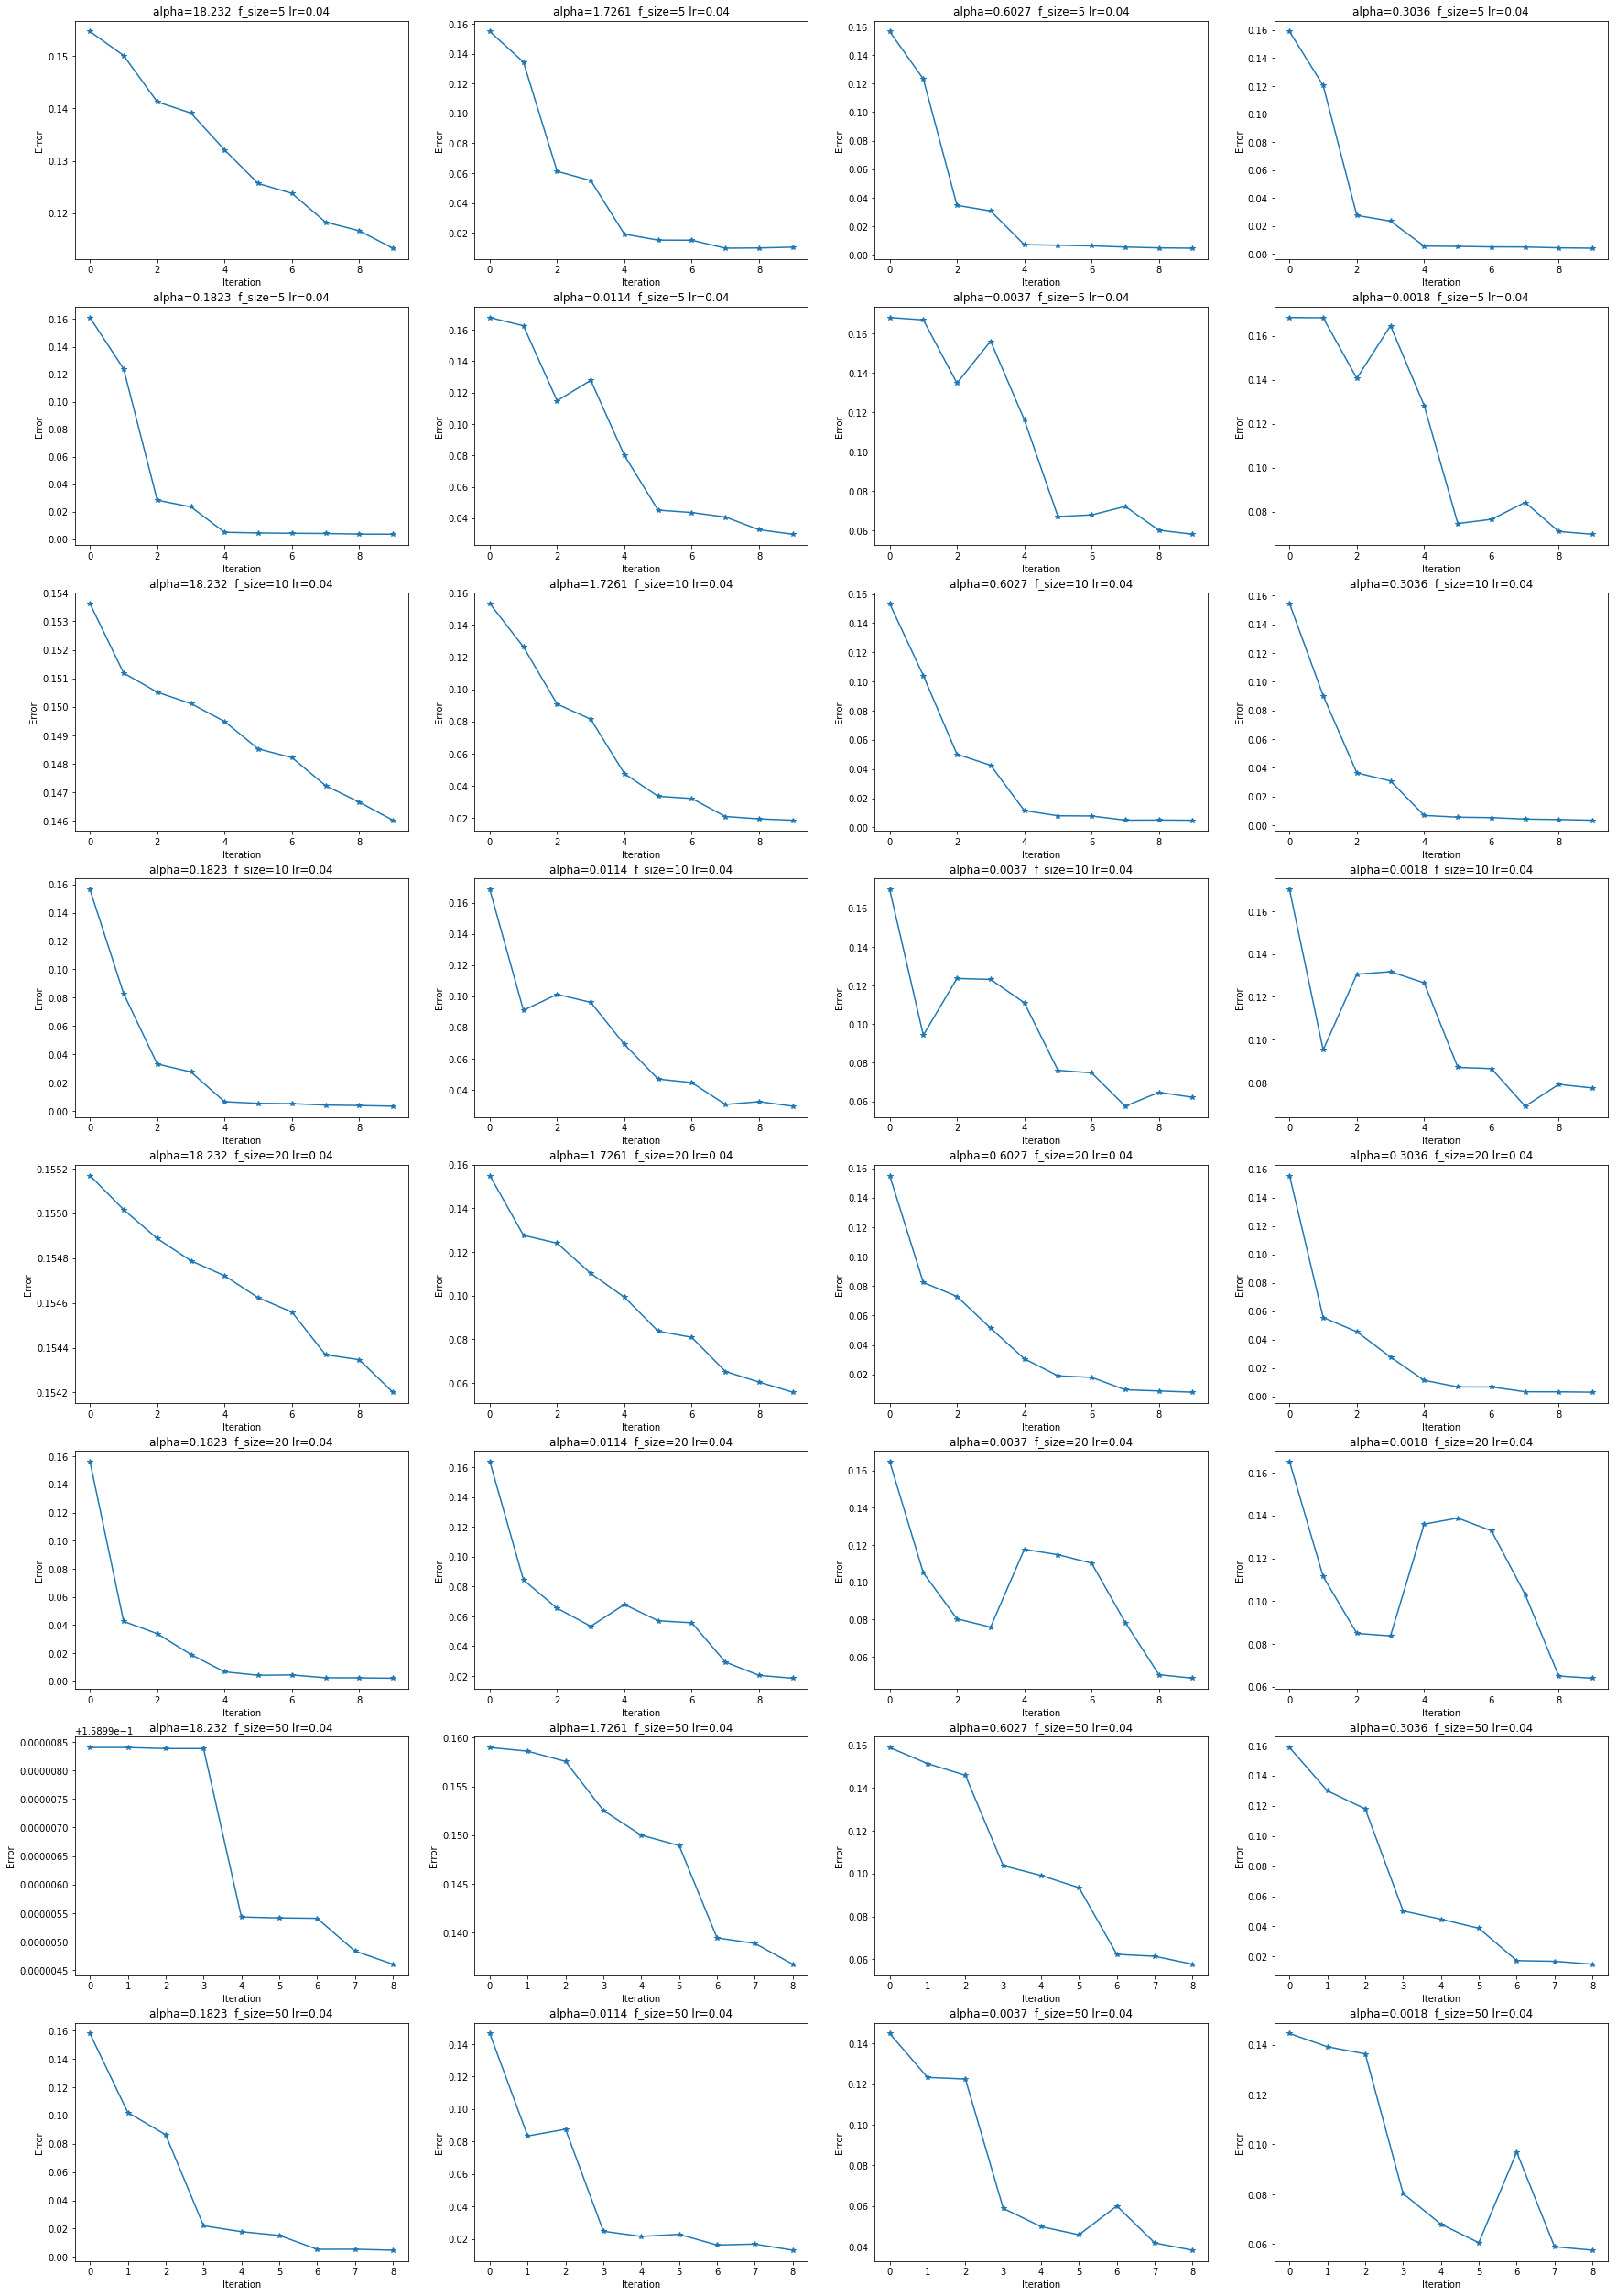

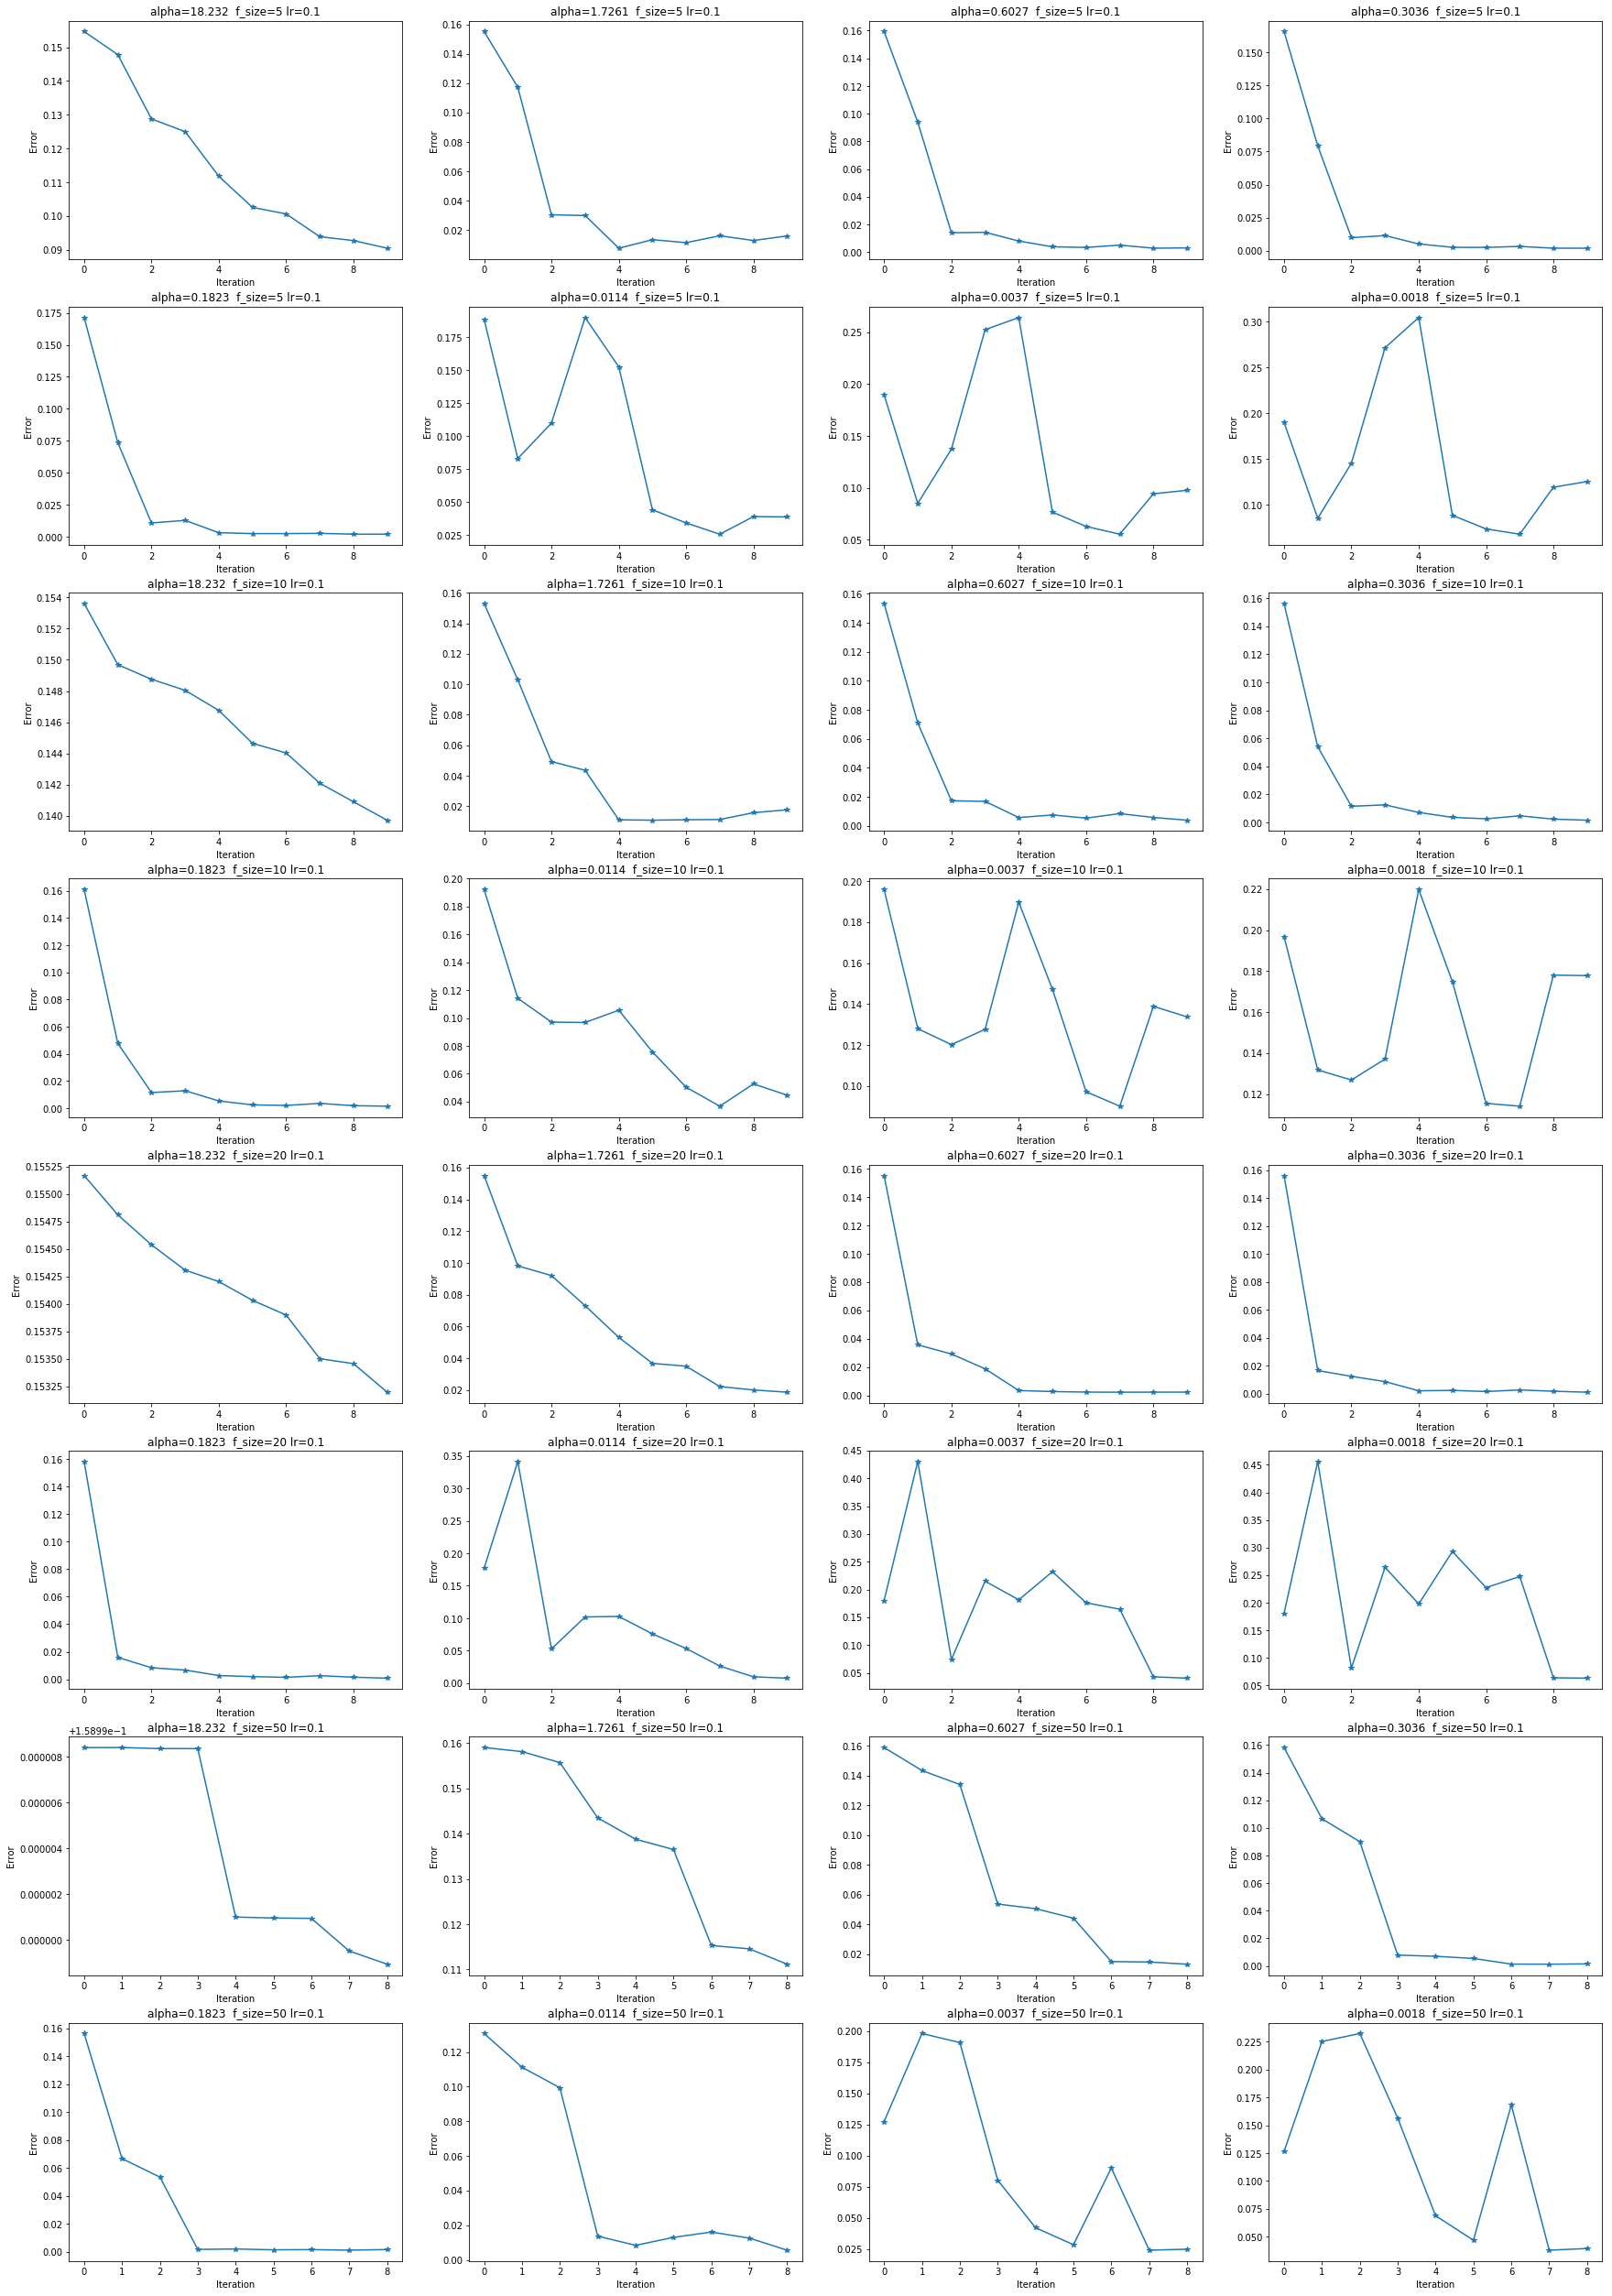

In [108]:
for j in range(len(lr_kernel)):
    fig = plt.figure(figsize=(30,45))
    n =0
    for i in range(len(alphas)*len(lr_kernel)*len(filter_size_kernel)):
        if result_klms["lr"][i] == lr_kernel[j]:
            fig.add_subplot(8, 4, n+1)
            n +=1 
            plt.plot(result_klms["error"][i], "*-")
            plt.title(result_klms["name"][i])
            plt.xlabel("Iteration")
            plt.ylabel("Error")
    address = "lr="+np.str(lr_kernel[j])+".png"
    plt.savefig(address)

# Comparison between LMS and KLMS

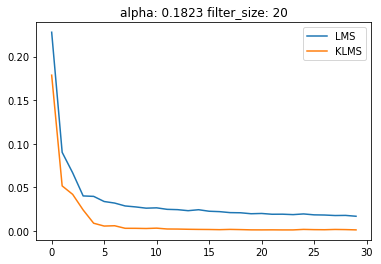

In [125]:
epochs = 3
filter_size = 20 
alpha = 0.1823
_, e_klms = KLMS_train(train, train_noisy ,test, test_noisy, filter_size , 0.04, "gaussian", alpha, epochs=epochs)
w, e_lms, _= LMS_train(train, train_noisy, test, test_noisy, filter_size, 0.008 , epochs=epochs)

plt.figure()
plt.plot(e_lms, label="LMS")
plt.plot(e_klms, label="KLMS")
plt.title("alpha: "+ np.str(alpha)+" filter_size: "+np.str(filter_size))
plt.legend()
plt.savefig("ver2")